In [2]:
import hydrofunctions as hf
import pandas as pd
import numpy as np
from zipfile import ZipFile
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
sns.set_style("ticks")

In [3]:
river='St_Clair_R'

location = (42.813370, -82.483370)

In [11]:
WSC_STATIONS.head()

,STATION_NUMBER,STATION_NAME,PROV_TERR_STATE_LOC,REGIONAL_OFFICE_ID,HYD_STATUS,SED_STATUS,LATITUDE,LONGITUDE,DRAINAGE_AREA_GROSS,DRAINAGE_AREA_EFFECT,RHBN,REAL_TIME,CONTRIBUTOR_ID,OPERATOR_ID,DATUM_ID,Level,Flow
688,02FD002,LUCKNOW RIVER AT LUCKNOW,ON,5,A,D,43.965279,-81.513443,54.900002,NaN,0,1,647.0,647.0,10.0,True,True
691,02FE002,MAITLAND RIVER BELOW WINGHAM,ON,5,A,NaN,43.886749,-81.326439,1640.000000,NaN,0,1,480.0,647.0,10.0,True,True
692,02FE003,MIDDLE MAITLAND RIVER NEAR LISTOWEL,ON,5,A,NaN,43.727230,-80.972671,73.400002,NaN,0,1,480.0,647.0,10.0,True,True
694,02FE005,MAITLAND RIVER ABOVE WINGHAM,ON,5,A,NaN,43.915081,-81.264389,527.000000,NaN,0,1,480.0,647.0,10.0,True,True
695,02FE007,LITTLE MAITLAND RIVER AT BLUEVALE,ON,5,A,NaN,43.854389,-81.250504,340.000000,NaN,0,1,480.0,647.0,10.0,True,True


In [30]:
WSC_STATIONS = pd.read_pickle('../Loadings Canada 2/data/WSC_STATIONS')
WSC_FLOWS = pd.read_pickle('../Loadings Canada 2/data/WSC_FLOWS')
WSC_STATIONS = WSC_STATIONS[WSC_STATIONS.Flow == True]

PWQMN = pd.read_pickle('../Loadings Canada 2/data/PWQMN')

elem = 'CHLORIDE,         UNFIL.REAC'
PWQMN = PWQMN[PWQMN["PARM DESCRIPTION"]==elem]
# PWQMN.loc[PWQMN.UNITS=='MICROGRAM PER LITER', "RESULT"] = PWQMN.RESULT/1000

PWQMN_LOC = pd.read_excel('../../measurements/PWQMN/PWQMN Locations.xlsx')

GLNI = pd.read_excel('../../measurements/GLNI/Canadian_Tributaries_concentrations_Serghei.xlsx', sheet_name='Data_GLNI_Erie tribs')

elem_name='Chloride dissolved'

GLNI = GLNI[GLNI.VariableCommonName==elem_name]

GLNI.SiteName.unique()

delta = 1

niagara_nurients = pd.read_excel('../../measurements/ECCC/Niagara River/Copy of Nutrients(1975-2018)-LowerConnectingChannels-Oct16-2018.xlsx')
eccc_name = 'Chloride dissolved'
eccc_stations = niagara_nurients[niagara_nurients.VariableCommonName == eccc_name][['SiteCode','Latitude','Longitude']]
eccc_stations = eccc_stations.rename(index=str, columns={'SiteCode':'STATION', 'Latitude':'Latitude'.upper(), 'Longitude':'Longitude'.upper()})

near_eccc_stations = eccc_stations[(eccc_stations.LATITUDE>location[0]-delta) & (eccc_stations.LATITUDE<location[0]+delta) &
                     (eccc_stations.LONGITUDE>location[1]-delta) & (eccc_stations.LONGITUDE<location[1]+delta)]


near_stations = WSC_STATIONS[(WSC_STATIONS.LATITUDE>location[0]-delta) & (WSC_STATIONS.LATITUDE<location[0]+delta) &
                     (WSC_STATIONS.LONGITUDE>location[1]-delta) & (WSC_STATIONS.LONGITUDE<location[1]+delta)]



near_pwqmn_stations = PWQMN_LOC[(PWQMN_LOC.LATITUDE>location[0]-delta) & (PWQMN_LOC.LATITUDE<location[0]+delta) &
                     (PWQMN_LOC.LONGITUDE>location[1]-delta) & (PWQMN_LOC.LONGITUDE<location[1]+delta)]


near_glni_stations = GLNI[(GLNI.Latitude>location[0]-delta) & (GLNI.Latitude<location[0]+delta) &
                     (GLNI.Longitude>location[1]-delta) & (GLNI.Longitude<location[1]+delta)]

near_glni_stations = near_glni_stations[['SiteCode','Latitude','Longitude']]

near_glni_stations = near_glni_stations.rename(index=str, columns={'SiteCode':'STATION', 'Latitude':'Latitude'.upper(), 'Longitude':'Longitude'.upper()})


PWQMN_IDS = [[st, False] for st in set(PWQMN.STATION.unique()).intersection(near_pwqmn_stations.STATION.unique())]

all_near_stations = pd.DataFrame({'STATION':[], 'LONGITUDE':[], 'LATITUDE':[]})

near_stations = near_stations[['STATION_NUMBER', 'LONGITUDE', 'LATITUDE']]

near_stations = near_stations.rename(index=str, columns={'STATION_NUMBER':'STATION'})


near_pwqmn_stations = near_pwqmn_stations[['STATION', 'LONGITUDE', 'LATITUDE']]

all_near_stations = pd.concat([near_stations, near_eccc_stations, near_pwqmn_stations, near_glni_stations])



/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [31]:
PWQMN_IDS = [[st, False] for st in near_pwqmn_stations.STATION.unique()]
GLNI_IDS = [[st, False] for st in near_glni_stations.STATION.unique()]
Flow_IDS = [[st, False] for st in near_stations.STATION.unique()]
ECCC_IDS = [[st, False] for st in near_eccc_stations.STATION.unique()]

In [63]:
import folium
# import folium.plugins as plugins
from folium.plugins import MiniMap
from folium.plugins.beautify_icon import BeautifyIcon
from folium.features import DivIcon



# m = folium.Map(width=500,height=300, location=location, zoom_start=11.,tiles="OpenStreetMap", attr='Global Water Futures')
m = folium.Map(width=700,height=500, 
                location=location,
               control_scale = True,
                 zoom_start=9.5,
               zoom_control=False,
                 tiles='https://tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=34dad269f6ab438c9534def56b86fa5f',
                 API_key='34dad269f6ab438c9534def56b86fa5f',
                attr='Global Water Futures')

# show all Flow
# for index, st_dic in enumerate(Flow_IDS):
#     st = st_dic[0]
# #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
# #     if N>10:
#     st_df = near_stations[near_stations.STATION == st]
#     folium.Marker(location=[st_df.LATITUDE.values[0], 
#                             st_df.LONGITUDE.values[0]], 
#                               popup=folium.Popup(html=st_df.STATION.values[0],
#                             show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
#                  ).add_to(m)



# # show all
# if 0:
#     for index, st_dic in enumerate(PWQMN_IDS):
#         st = st_dic[0]
#     # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
#     # #     if N>10:
#         st_df = near_pwqmn_stations[near_pwqmn_stations.STATION == st]
#         folium.Marker(location=[st_df.LATITUDE.values[0], 
#                                 st_df.LONGITUDE.values[0]], 
#                                   popup=folium.Popup(html=str(st_df.STATION.values[0]),
#                                 show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
#                      ).add_to(m)
#     for index, st_dic in enumerate(GLNI_IDS):
#         st = st_dic[0]
#     # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
#     # #     if N>10:
#         st_df = near_glni_stations[near_glni_stations.STATION == st]
#         folium.Marker(location=[st_df.LATITUDE.values[0], 
#                                 st_df.LONGITUDE.values[0]], 
#                                   popup=folium.Popup(html=str(st_df.STATION.values[0]),
#                                 show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='green')
#                      ).add_to(m)
#     for index, st_dic in enumerate(Flow_IDS):
#         st = st_dic[0]
#     # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
#     # #     if N>10:
#         st_df = near_stations[near_stations.STATION == st]
#         folium.Marker(location=[st_df.LATITUDE.values[0], 
#                                 st_df.LONGITUDE.values[0]], 
#                                   popup=folium.Popup(html=str(st_df.STATION.values[0]),
#                                 show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='red')
#                      ).add_to(m)
#     for index, st_dic in enumerate(ECCC_IDS):
#         st = st_dic[0]
#     # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
#     # #     if N>10:
#         st_df = near_eccc_stations[near_eccc_stations.STATION == st]
#         folium.Marker(location=[st_df.LATITUDE.values[0], 
#                                 st_df.LONGITUDE.values[0]], 
#                                   popup=folium.Popup(html=str(st_df.STATION.values[0]),
#                                 show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='blue')
#                      ).add_to(m)
# else:
Show_IDS = [
    ["02GG014", True],
]





for index, st_dic in enumerate(Show_IDS):
    st = st_dic[0]
    print(st)
    if st_dic[1]:
        clr='#f44242'
    else:
        clr='#0b15c4'
    st_df = all_near_stations[all_near_stations.STATION == st]
    folium.CircleMarker(location=[st_df.LATITUDE.values[0], 
                            st_df.LONGITUDE.values[0]], radius=23, 
                        fill=True, fill_color='white',
                            color = clr,fill_opacity=1,
                       weight=5).add_to(m)
    if not index+1 in [1,4]:
        folium.map.Marker(
#             location=[st_df.LATITUDE.values[0]+0.0235,st_df.LONGITUDE.values[0]-0.1026], # 10 km
        location=[st_df.LATITUDE.values[0]+0.0135,st_df.LONGITUDE.values[0]-0.0526], # 5km
#             location=[st_df.LATITUDE.values[0]+0.0065,st_df.LONGITUDE.values[0]-0.026], # 2km
#             location=[st_df.LATITUDE.values[0]+0.003,st_df.LONGITUDE.values[0]-0.013], # 1km
#         location=[st_df.LATITUDE.values[0]+0.0015,st_df.LONGITUDE.values[0]-0.0064], # 500m
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 24pt;text-align: center;vertical-align: middle">{}</div>'.format(index+1),
            )
        ).add_to(m)


for idx, st_df in enumerate(sts):
    folium.CircleMarker(location=[st_df["LATITUDE"], 
                            st_df["LONGITUDE"]], radius=23, 
                        fill=True, fill_color='white',
                            color = '#f44242',fill_opacity=1,
                       weight=5).add_to(m)
    # if not index+1 in []:
    folium.map.Marker(
    location=[st_df["LATITUDE"]+0.0235,st_df["LONGITUDE"]-0.1026], # 10 km
    #             location=[st_df.LATITUDE.values[0]+0.0135,st_df.LONGITUDE.values[0]-0.0526], # 5km
    #             location=[st_df.LATITUDE.values[0]+0.0065,st_df.LONGITUDE.values[0]-0.026], # 2km
    #             location=[st_df.LATITUDE.values[0]+0.003,st_df.LONGITUDE.values[0]-0.013], # 1km
    #         location=[st_df.LATITUDE.values[0]+0.0015,st_df.LONGITUDE.values[0]-0.0064], # 500m
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt;text-align: center;vertical-align: middle">{}</div>'.format(idx+1),
        )
    ).add_to(m)




m


# ON02HA0045
# ON02HA0019


02GG014


In [54]:
st_df

,LATITUDE,LONGITUDE,STATION
862,42.986939,-82.424721,02GG014


In [58]:
sts = [{ 'LATITUDE': 42.656342, 'LONGITUDE': -82.508439 }, { 'LATITUDE': 42.975956, 'LONGITUDE': -82.413531 }]

In [38]:
selected_stations = [s[0] for s in Show_IDS] , 

In [39]:
Port_Lambton = pd.read_excel('../../measurements/ECCC/ST_Clair_River_Concentrations_from_Dabbie.xlsx', sheet_name='Port_Lambton')


In [40]:
Point_Edward = pd.read_excel('../../measurements/ECCC/ST_Clair_River_Concentrations_from_Dabbie.xlsx', sheet_name='Point_Edward')



In [41]:
Point_Edward.head()

,yyyymmdd,ammonia,chloride,nitrate,TKN,TP,SO4,TDP
0,20001002,<0.005,8.05,0.294,0.18,0.0073,17.2,NaN
1,20001016,<0.005,7.20,0.327,0.15,0.0069,11.2,NaN
2,20001101,0.005,7.48,0.326,0.21,0.0255,16.2,NaN
3,20001111,0.005,7.70,0.329,0.24,0.0280,15.5,NaN
4,20001128,0.005,6.14,0.325,0.22,0.0394,16.6,NaN


In [42]:
Port_Lambton.head()

,yyyymmdd,Ammonia,chloride,nitrate,TKN,TP,SO4,TDP
0,20001002,0.010,6.78,0.327,0.17,0.0088,16.6,NaN
1,20001016,0.049,6.84,0.363,0.24,0.0120,14.4,NaN
2,20001101,0.005,6.83,0.339,0.28,0.0516,16.5,NaN
3,20001110,0.005,6.73,0.373,0.17,0.0192,16.2,NaN
4,20001128,0.008,6.36,0.334,0.20,0.0490,15.9,NaN


In [43]:
Port_Lambton['Station'] = 'Port Lambton'
Point_Edward['Station'] = 'Point Edward'


In [44]:
for c in Point_Edward.columns:
    Point_Edward = Point_Edward.rename(index=str, columns={c: c.lower().strip()})

In [45]:
for c in Port_Lambton.columns:
    Port_Lambton = Port_Lambton.rename(index=str, columns={c: c.lower().strip()})

In [46]:
Port_Lambton.columns

Index(['yyyymmdd', 'ammonia', 'chloride', 'nitrate', 'tkn', 'tp', 'so4', 'tdp',
       'station'],
      dtype='object')

In [47]:
Point_Edward.columns

Index(['yyyymmdd', 'ammonia', 'chloride', 'nitrate', 'tkn', 'tp', 'so4', 'tdp',
       'station'],
      dtype='object')

In [65]:
res = pd.concat([Port_Lambton, Point_Edward])
res['chloride'] = pd.to_numeric(res['chloride'])
res['yyyymmdd'] = pd.to_datetime(res['yyyymmdd'], format='%Y%m%d', errors='coerce')

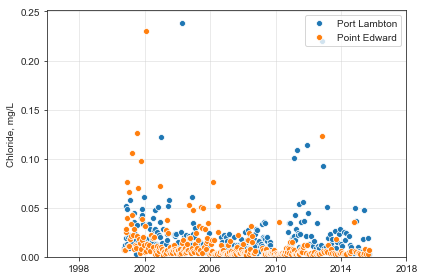

In [108]:
## fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

ax = sns.scatterplot(res[res.station=='Port Lambton']['yyyymmdd'], res[res.station=='Port Lambton']['tp'], markers=True, label='Port Lambton')
ax = sns.scatterplot(res[res.station=='Point Edward']['yyyymmdd'], res[res.station=='Point Edward']['tp'], markers=True, label='Point Edward')
leg = ["({}) - {}".format(i+1,st) for i, st in enumerate(selected_stations)]

# leg_handles = ax.get_legend_handles_labels()[0]
# ax.legend(leg_handles[1:], leg, title='Stations', fontsize='x-small', loc='best')

# ax.legend(['(1) - HTLP (NCWQR)'], title='Stations', fontsize='x-small', loc=2)
ax.legend(loc=1)

plt.ylim(0,None)
plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Chloride, mg/L")
plt.xlabel("")
plt.tight_layout()
plt.savefig('Rivers/'+river+'/'+river+'_TP.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl_meas.pdf')



In [69]:
print(res.groupby('station')["tp"].describe().round(2).to_latex())
      

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &   std &  min &   25\% &   50\% &   75\% &   max \\
station      &        &       &       &      &       &       &       &       \\
\midrule
Point Edward &  318.0 &  0.01 &  0.02 &  0.0 &  0.00 &  0.01 &  0.01 &  0.23 \\
Port Lambton &  303.0 &  0.02 &  0.02 &  0.0 &  0.01 &  0.01 &  0.02 &  0.24 \\
\bottomrule
\end{tabular}



In [71]:
selected_stations

(['02GG014'],)

In [73]:
res['USGSPCode'] = 0
res['DATE'] = res['yyyymmdd']
res['RESULT'] = res['tp']

In [74]:
res[['DATE','USGSPCode', 'RESULT']].groupby('DATE').mean().reset_index().sort_values('DATE').to_csv(
    'Rivers/'+river+'/TP_'+river+'iver_data.csv', index=False)

### Discharge

In [4]:
river

'St_Clair_R'

In [5]:
discharge = pd.read_excel('../../measurements/ECCC/Discharge_StClair_Detroit_Niagara_Sydenhame_Thames.xlsx', sheet_name='discharge_cms')



for c in discharge.columns:
    discharge = discharge.rename(
        index=str, columns={c: c.lower().strip()})

discharge['date'] = pd.to_datetime(discharge[['year', 'month', 'day']])

discharge = discharge[['date', 'stclair_r']]


discharge['Discharge, cms']  = discharge['stclair_r']
discharge['Flow, CFS'] = discharge['Discharge, cms']/0.028

In [81]:
site = '02GG014'
discharge = WSC_FLOWS[WSC_FLOWS.index>datetime.datetime(1996,1,1)][site].to_frame()

discharge = discharge.reset_index()
discharge = discharge.rename(index=str, columns={site:'Discharge, cms', 'index':'Date'})
discharge['Source'] = site

discharge['Flow, CFS'] = discharge['Discharge, cms']/0.028

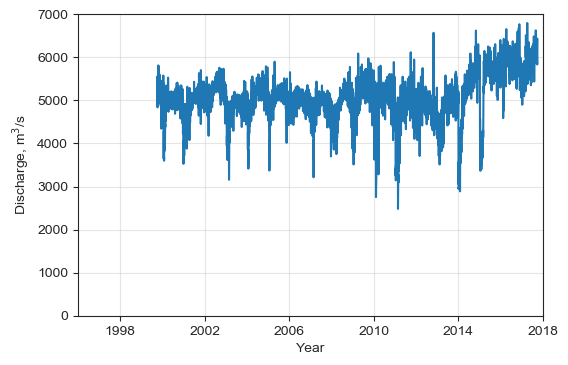

In [6]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(x='date', y='Discharge, cms', data=discharge,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc='best', fontsize='small')
ax.set_ylim(0,None)
ax.set_xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig('Rivers/'+river+'/'+river+'_Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Q.pdf')

In [7]:
discharge[['date', 'Flow, CFS']].to_csv('Rivers/'+river+'/Flow_'+river+'_CFS.csv', index=False)

### Egret

In [8]:
river

'St_Clair_R'

In [9]:

EGRET_Daily = pd.read_csv('Rivers/'+river+'/EGRET Result/Cl/'+river+'iver_Cl_Daily.csv')
EGRET_Sample = pd.read_csv('Rivers/'+river+'/EGRET Result/Cl/'+river+'iver_Cl_Sample.csv')


EGRET_Sample['Fx_Hat'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcHat']/1000/1000
EGRET_Sample['Fx_C'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcAve']/1000/1000


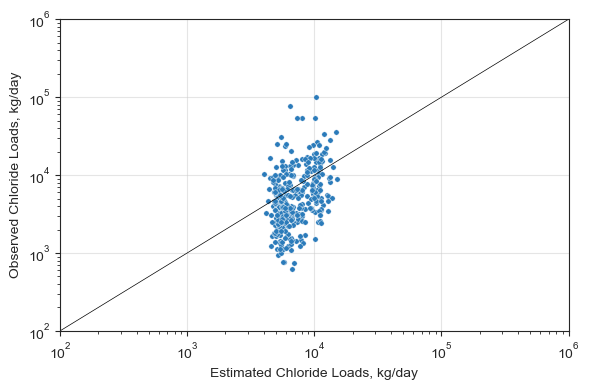

In [10]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
sns.scatterplot(y='Fx_C', 
                x='Fx_Hat',
                data=EGRET_Sample,
                s=15,
                linewidth=0.3, ax=ax,
               color=sns.color_palette("Blues")[4])
# plt.legend("")
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot([-100,100000000],[-100,100000000], 'k', lw=0.5)
min_lim, max_lim = 1e2, 1e6
plt.xlim(min_lim,max_lim)
plt.ylim(min_lim,max_lim)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.xlabel("Estimated Chloride Loads, kg/day")
plt.ylabel("Observed Chloride Loads, kg/day")
# plt.xlabel("")
plt.tight_layout()
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_FvsF.pdf')


In [11]:
EGRET_Daily['FluxYearMTA'] = EGRET_Daily['FluxDay']*365/1000
EGRET_Daily['Fx_SE'] = (np.exp(EGRET_Daily['SE']+EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000-np.exp(EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000)*365
EGRET_Daily_an = EGRET_Daily.groupby('waterYear').mean().reset_index()


EGRET_Daily_an

,waterYear,Unnamed: 0,Q,Julian,Month,Day,DecYear,MonthSeq,i,LogQ,Q7,Q30,yHat,SE,ConcDay,FluxDay,FNConc,FNFlux,FluxYearMTA,Fx_SE
0,2000,183.5,5019.374578,54876.5,6.513661,183.500000,2000.248889,1803.497268,183.5,8.518511,5015.547995,5000.692687,-3.847536,0.748400,0.028652,12479.271667,0.029495,13194.683652,4554.934158,3834.047013
1,2001,549.0,4901.112190,55242.0,6.526027,183.838356,2001.248374,1815.501370,549.0,8.494569,4898.304650,4896.651569,-3.994356,0.749093,0.024595,10415.360908,0.026144,11689.353892,3801.606731,3198.050734
2,2002,914.0,5247.036127,55607.0,6.526027,183.838356,2002.248288,1827.501370,914.0,8.564490,5247.718105,5240.650109,-4.025875,0.749855,0.023830,10795.984139,0.023242,10382.599934,3940.534211,3320.479378
3,2003,1279.0,4904.716965,55972.0,6.526027,183.838356,2003.248288,1839.501370,1279.0,8.494208,4907.300430,4924.222669,-4.213664,0.751274,0.019868,8459.597940,0.020739,9254.841147,3087.753248,2603.767829
4,2004,1644.5,5048.103108,56337.5,6.513661,183.500000,2004.248889,1851.497268,1644.5,8.523566,5043.857888,5029.544935,-4.291524,0.753196,0.018276,7965.419747,0.018559,8270.112610,2907.378208,2456.229493
5,2005,2010.0,5117.716047,56703.0,6.526027,183.838356,2005.248374,1863.501370,2010.0,8.538337,5120.048484,5125.378900,-4.390849,0.755777,0.016613,7350.985412,0.016660,7414.840013,2683.109675,2275.708981
6,2006,2375.0,5045.527380,57068.0,6.526027,183.838356,2006.248288,1875.501370,2375.0,8.525463,5047.184255,5052.147857,-4.513274,0.758125,0.014716,6413.242309,0.014970,6648.550641,2340.833443,1993.628576
7,2007,2740.0,4883.492637,57433.0,6.526027,183.838356,2007.248288,1887.501370,2740.0,8.491741,4884.114471,4886.277880,-4.616813,0.757212,0.013245,5579.460036,0.013416,5937.086035,2036.502913,1730.850202
8,2008,3105.5,4849.970509,57798.5,6.513661,183.500000,2008.248889,1899.497268,3105.5,8.483476,4846.789236,4837.761040,-4.656123,0.754334,0.012681,5288.024594,0.012381,5452.338967,1930.128977,1632.544897
9,2009,3471.0,5184.764805,58164.0,6.526027,183.838356,2009.248374,1911.501370,3471.0,8.549589,5182.272589,5174.693104,-4.682420,0.756631,0.012378,5515.424094,0.012368,5443.941082,2013.129794,1707.446483


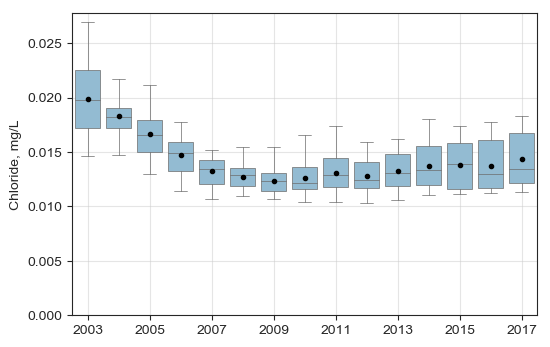

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

# sns.boxplot(EGRET_Daily['waterYear'], EGRET_Daily['ConcDay'], color=sns.color_palette()[0])

# plt.fill_between(EGRET_Daily_an['waterYear'][5:-1],
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]-EGRET_Daily_an['SE'][5:-1]),
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]+EGRET_Daily_an['SE'][5:-1]), 
#                  color=sns.color_palette()[0], alpha=0.15)
# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

meanpointprops = dict(marker='.', markeredgecolor='black', markersize=6,markerfacecolor='black')
ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", 
                 data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2],
                order=range(2003,2019))

# ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
# plt.xlim(2003,2018)
plt.xlim(-0.5, 14.5)
locs, labels = plt.xticks() 
plt.xticks(locs[::2], labels[::2])
plt.ylim(0,None)
# plt.vlines(4.5, 0, 0.6, 'k', '-.', lw=0.7)
# plt.vlines(9.5, 0, 0.6, 'k', '-.', lw=0.7)

# ax.set_xticks([int(x) for x in np.linspace(2003,2017, 8)])

plt.grid(alpha=0.5)
plt.ylabel("Chloride, mg/L")
plt.xlabel("")
# fig.autofmt_xdate()
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl.pdf')




In [13]:
EGRET_Daily_an['Fx_AE'] = (abs(EGRET_Sample['Fx_Hat'] - EGRET_Sample['Fx_C'])/EGRET_Sample['Fx_C']).mean()*EGRET_Daily_an['FluxYearMTA']




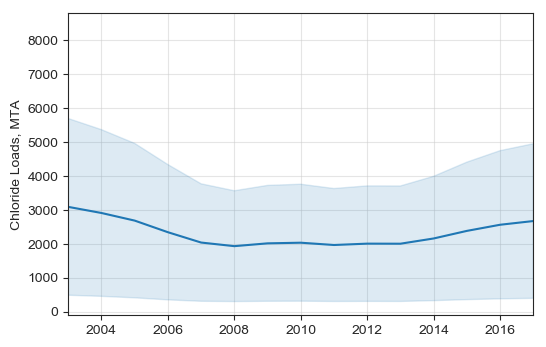

In [14]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

k=None
plt.plot(EGRET_Daily_an['waterYear'][:k], EGRET_Daily_an['FluxYearMTA'][:k], c=sns.color_palette()[0])

# s=12
# plt.plot(EGRET_Daily_an['waterYear'][s:], EGRET_Daily_an['FluxYearMTA'][s:], c=sns.color_palette()[0])

plt.fill_between(EGRET_Daily_an['waterYear'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]-EGRET_Daily_an['Fx_SE'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]+EGRET_Daily_an['Fx_SE'][:k], 
                 color=sns.color_palette()[0], alpha=0.15)

# plt.fill_between(EGRET_Daily_an['waterYear'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]-EGRET_Daily_an['Fx_SE'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]+EGRET_Daily_an['Fx_SE'][s:], 
#                  color=sns.color_palette()[0], alpha=0.15)



# plt.vlines(2007, 0, 200, 'k', '-.', lw=0.7)
# plt.vlines(2013, 0, 200, 'k', '-.', lw=0.7)


# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

# meanpointprops = dict(marker='D', markeredgecolor='black', markersize=1,markerfacecolor=sns.color_palette()[3])
# ax = sns.boxplot(linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="FluxYearMTA", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
plt.xlim(2003,2017)
# plt.xticks([int(x) for x in np.linspace(5,19,8)], [int(x) for x in np.linspace(2003,2017, 8)])
# plt.ylim(0,200)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Chloride Loads, MTA")
plt.xlabel("")
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables_chloride/img/Rivers/Canada/'+river+'/'+river+'_Cl_Flux.pdf')


In [15]:
print(EGRET_Daily_an[(EGRET_Daily_an.waterYear<2018) & (EGRET_Daily_an.waterYear>2002)][['waterYear', 'FluxYearMTA','Fx_SE']].round(1).T.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
     3  &      4  &      5  &      6  &      7  &      8  &      9  &      10 &      11 &      12 &      13 &      14 &      15 &      16 &      17 \\
\midrule
 2003.0 &  2004.0 &  2005.0 &  2006.0 &  2007.0 &  2008.0 &  2009.0 &  2010.0 &  2011.0 &  2012.0 &  2013.0 &  2014.0 &  2015.0 &  2016.0 &  2017.0 \\
 3087.8 &  2907.4 &  2683.1 &  2340.8 &  2036.5 &  1930.1 &  2013.1 &  2031.7 &  1964.2 &  2004.4 &  2002.2 &  2156.6 &  2380.0 &  2560.8 &  2670.2 \\
 2603.8 &  2456.2 &  2275.7 &  1993.6 &  1730.9 &  1632.5 &  1707.4 &  1723.4 &  1664.1 &  1701.4 &  1701.4 &  1832.0 &  2025.8 &  2183.2 &  2277.2 \\
\bottomrule
\end{tabular}

